# Projection à partir de la série différenciée et désaisonnaliée

## Package List:

In [3]:
require(forecast)
require(TSA)
require(fArma)
require(smooth)
require(Mcomp)
library(plyr)
library(ChainLadder)

Ici on va procéder à une projection qui est basé par la méthode de différentiation via les séries $SARIMA(p,d,r,q)$ où $d=1$ et $r=10$ dans notre cas. Pour les autres paramètres, on va les estimer soit selon la MSE soit selon les critères AKAIK et le critère de Schwarz.

Notons : $Z_t=\Delta_r \Delta X_t=\epsilon_t$ cette série. Ce qui va nous donner
$Z_t=(1-L^r)(1-L)X_t=(1-L^r-L+L^{r+1})X_t=X_t-X_{t-r}-X_{t-1}+X_{t-r-1}$
Pour notre cas, on va prendre $r=10$ donc on a que:
$$Z_t=X_t-X_{t-10}-X_{t-1}+X_{t-11}=\epsilon_t$$
Sous $R$,on va prendre $t \in [12,88]$ pour les indices de $X_t$

In [4]:
Z_t<-function(fit,L=90,r=10){
    Z=c()
    temp=0
    for(i in 1:L){
        if(i<=r+1){
            Z=c(Z,0)
        }else{
            temp=fit[i]-fit[i-r]-fit[i-1]+fit[i-r-1]
            Z=c(Z,temp)
        }
    }
    return(Z)
}

## Extraction des données

In [5]:
donne<-read.csv("/home/tantely/Documents/IMSA/Projet_TER/otherliab_pos.csv",sep=',')
OL <- donne[donne$DevelopmentYear<1998,]

PaidTri <- as.triangle(OL, origin="AccidentYear", dev="DevelopmentLag", value="CumPaidLoss")
PaidTri_non <- as.triangle(OL, origin="AccidentYear", dev="DevelopmentLag", value="NonCumPaidLoss")
#print(LossTri)
print("Paiemement cummulé")
M1=as.matrix(PaidTri)
colnames(M1)<-0:9
M1
print("Piement non cummulé")
M2=as.matrix(PaidTri_non)
colnames(M2)<-0:9
M2

[1] "Paiemement cummulé"


,0,1,2,3,4,5,6,7,8,9
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040,111473
1989,6387,17842,35429,57222,80791,95150,103731,112450,113114,NA
1990,8347,18022,36758,71537,87621,100813,121789,122055,NA,NA
1991,7700,21502,43272,64383,78572,93042,100276,NA,NA,NA
1992,8223,23181,37376,52041,72611,76059,NA,NA,NA,NA
1993,12122,26156,48834,82909,94462,NA,NA,NA,NA,NA
1994,7596,19404,65507,111264,NA,NA,NA,NA,NA,NA
1995,10264,44816,62018,NA,NA,NA,NA,NA,NA,NA
1996,20162,28107,NA,NA,NA,NA,NA,NA,NA,NA
1997,10682,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "Piement non cummulé"


,0,1,2,3,4,5,6,7,8,9
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423,1433
1989,6387,11455,17587,21793,23569,14359,8581,8719,664,NA
1990,8347,9675,18736,34779,16084,13192,20976,266,NA,NA
1991,7700,13802,21770,21111,14189,14470,7234,NA,NA,NA
1992,8223,14958,14195,14665,20570,3448,NA,NA,NA,NA
1993,12122,14034,22678,34075,11553,NA,NA,NA,NA,NA
1994,7596,11808,46103,45757,NA,NA,NA,NA,NA,NA
1995,10264,34552,17202,NA,NA,NA,NA,NA,NA,NA
1996,20162,7945,NA,NA,NA,NA,NA,NA,NA,NA
1997,10682,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [6]:
paid_loss<-ts(donne$NonCumPaidLoss,start =c(1988,1),end=c(1997,10),frequency=10)

## Echantillonnage:
On va utiliser le données train pour effectuer l'apprentissage et test pour faire les tests staitsitques.

In [7]:
fit.train<-paid_loss[1:80]
fit.test<-paid_loss[81:100]

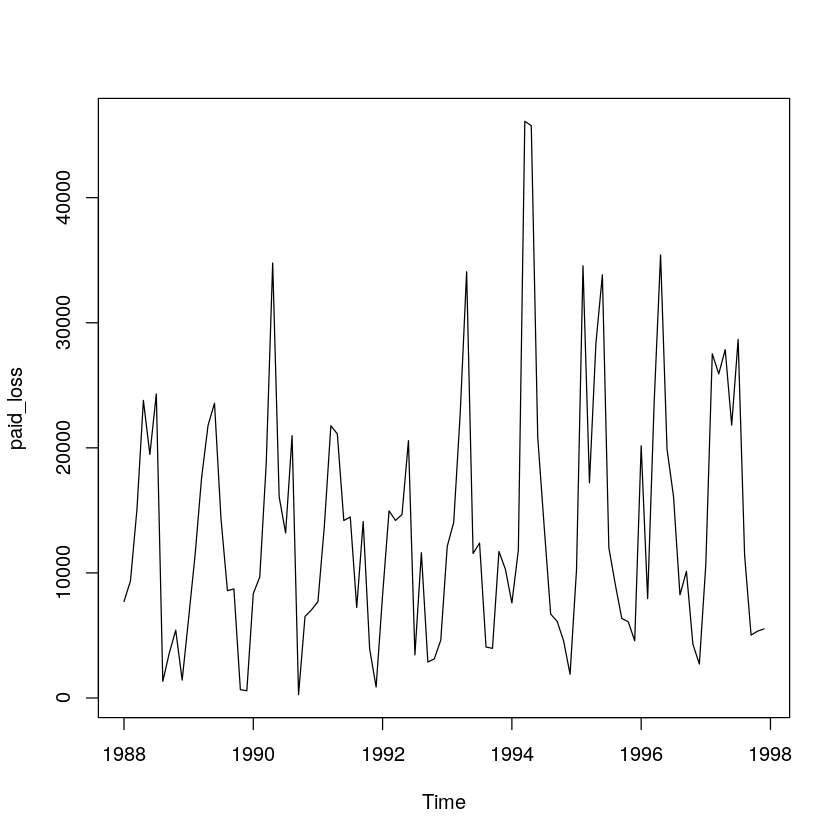

In [8]:
plot(paid_loss,type="l")

## Stationnarisation de la série par projection:

In [9]:
Z<-Z_t(fit.train,L=80,r=10)
(ts(Z))

Time Series:
Start = 1 
End = 80 
Frequency = 1 
 [1]      0      0      0      0      0      0      0      0      0      0
[11]      0   3427    433  -4527   6098 -14051  17205  -2112  -9900   3906
[21]   2813  -3740   2929  11837 -20471   6318  13562 -20848  14307    611
[31]  -7112   4774  -1093 -16702  11773   3173 -15020  27585 -16438  -3573
[41]   6691    633  -8731   1129  12827 -17403  15402 -15614  10441   4538
[51]    154  -4823   9407  10927 -28427  17955 -16478   8634   7490  -2918
[61] -10192   2300  25651 -11743  -2402  -7992   1349   -478  -9300  -1249
[71]  11058  20076 -51645  11502  30396 -14660   4022  -2129   1290   1155

## stationnarité de la série:

In [10]:
pp.test(ts(Z))
adf.test(ts(Z))

Warning message in pp.test(ts(Z)):
“p-value smaller than printed p-value”


	Phillips-Perron Unit Root Test

data:  ts(Z)
Dickey-Fuller Z(alpha) = -95.903, Truncation lag parameter = 3, p-value
= 0.01
alternative hypothesis: stationary


Warning message in adf.test(ts(Z)):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  ts(Z)
Dickey-Fuller = -6.5503, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Les testes statistiques ont bien l'air d'être significatives. Donc, on peut valider le modèle.

## estimation en série ARMA(p,q) des bruits

### Estimation selon les critères AKAIK et BIC avec la package forecast

In [12]:
arma<-auto.arima(ts(Z))
summary(arma)

Series: ts(Z) 
ARIMA(4,0,0) with zero mean 

Coefficients:
          ar1      ar2      ar3      ar4
      -0.9786  -0.9404  -0.4938  -0.2341
s.e.   0.1083   0.1425   0.1414   0.1057

sigma^2 estimated as 74209083:  log likelihood=-837.09
AIC=1684.18   AICc=1684.99   BIC=1696.09

Training set error measures:
                   ME     RMSE      MAE      MPE    MAPE      MASE       ACF1
Training set 125.1495 8396.346 6014.746 168.5199 253.939 0.3926324 -0.0436675


On remarque que l'on a un $ARMA(4,0)$ comme modèle. Faisons maintenant le test de l'indépendance des bruits de notre série $ARMA(4,0)$.

In [13]:
Box.test(arma$residuals,type=c("Ljung-Box"))


	Box-Ljung test

data:  arma$residuals
X-squared = 0.15834, df = 1, p-value = 0.6907


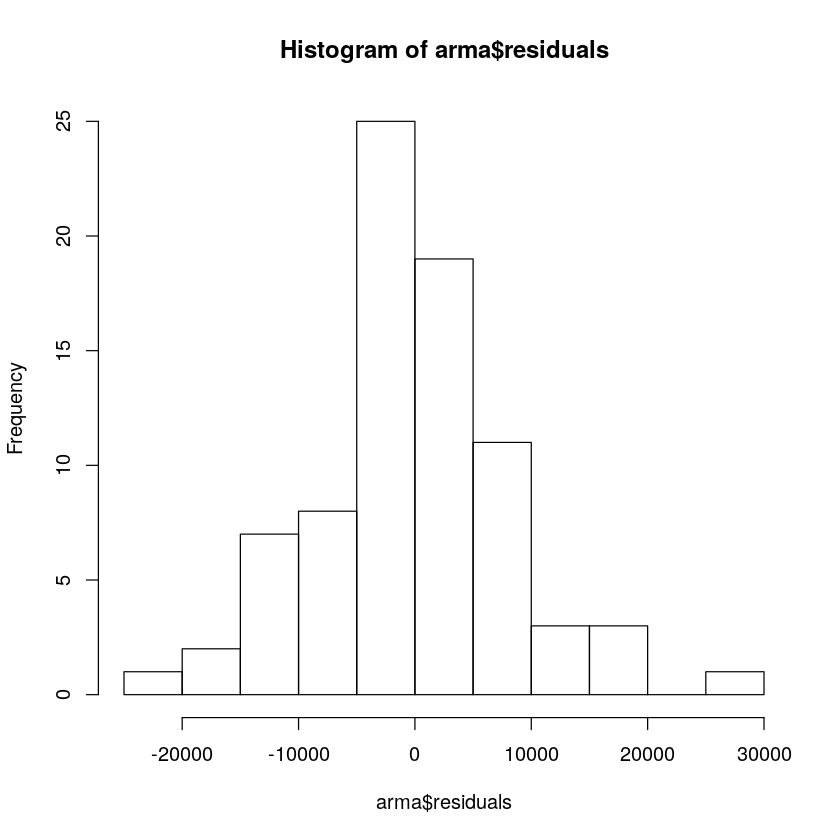

In [14]:
hist(arma$residuals)

Le teste statistique de "Ljung-Box" à bien l'air d'être significative, donc on en conclut que notre modèle $ARMA(4,0)$ est bien construit.

### Test de normalité

In [16]:
jarque.bera.test(arma$residuals)


	Jarque Bera Test

data:  arma$residuals
X-squared = 2.4482, df = 2, p-value = 0.294


On a un $p-value>5\%$ donc le test significative. Les Bruits  sont donc pas gaussienne.

## Prédiction 
Pour faire la prédiction, nous sommes allés itérer la formule, et comme on a des sommes télescopiques, on va obtenir:
$$\hat{X}_t=\sum^{t}_{i=r+2}Z_i+X_{11}+X_{t-r}-X_1$$

In [17]:
#Cette fonction ne marche que pour r=10.
Prediction<-function(X,T,t,r=10,arma_mod){
    if(T>=t){
        return(X[t])
    }
    X_r=0
    temp=forecast(arma_mod,h=t-T)
    Z=sum(c(temp$mean,arma_mod$x[(r+2):T]))
    cste=X[11]-X[1]
    if(t-r>T){
        return(Z+cste+Prediction(X,T,t-r,r,arma_mod))
    }else{
         return(Z+cste+X[t-r])
    }
}

In [18]:
Val_pred<-function(X=fit.train,T=length(fit.train),h=length(fit.test),r=10,arma_m=arma){
    res=c()
    for(i in 1:h){
        res=c(res,Prediction(X,T,t=i+T,r=10,arma_mod=arma_m))
    }
    return(res)
}

In [19]:
pred=Val_pred()

In [20]:
MSE=mean((pred-fit.test)^2)
akaik=arma$aic
bic=BIC(arma)
Ljung_Box=0.5657
p_q="(4,0)"
table<-cbind(p_q,Ljung_Box,akaik,bic,MSE)
table

p_q,Ljung_Box,akaik,bic,MSE
"(4,0)",0.5657,1684.18206639507,1696.09219956843,89755685.7048487


In [21]:
delta=sqrt(var(pred))*1.96

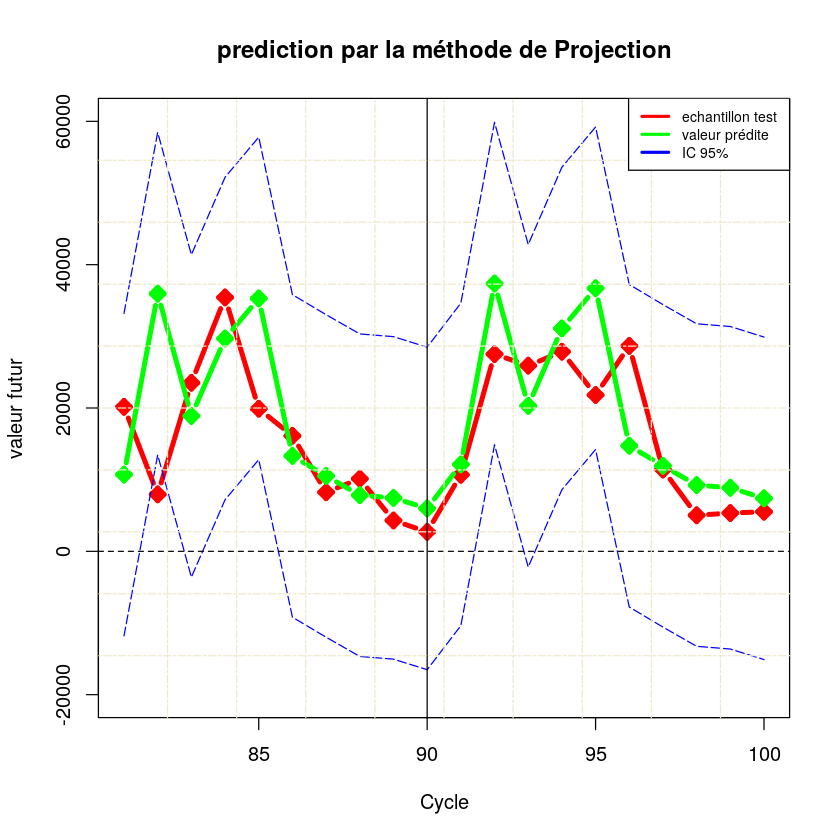

In [22]:
plot(time(fit.test)+length(fit.train),fit.test,type="b",
     col="red",main="prediction par la méthode de Projection",pch=9,lwd=4,ylim=c(-20000,60000),xlab="Cycle",ylab="valeur futur")
points(time(fit.test)+length(fit.train),pred,type="b",lwd=4,pch=9,col="green")
points(time(fit.test)+length(fit.train),pred+delta,type="l",lty=5,col="blue")
points(time(fit.test)+length(fit.train),pred-delta,type="l",lty=5,col="blue")
abline(h=0,lty=8)
abline(v=90,lty=1,pch=9)
grid (10,10, lty = 6, col = "cornsilk2")
legend("topright",c("echantillon test","valeur prédite","IC 95%"),col=c("red","green","blue"),lty=c(1,1),lwd=c(2.5,2.5),cex=0.7)